In [1]:
var openDigger = require('../src/open_digger')

In [2]:
var query = openDigger.driver.clickhouse.query;

In [3]:
query(`SHOW DATABASES`).then(res=>{console.log(res)})

[
  { name: '_temporary_and_external_tables' },
  { name: 'default' },
  { name: 'github_log' },
  { name: 'system' }
]


In [4]:
var repo_id = '65600975'
var startYear=2015, endYear=2021;

项目在数据库中最早记录时间

In [5]:
query(
    `SELECT repo_name, created_at from github_log.events where repo_id=${repo_id} order by created_at ASC limit 1`
).then(res=>{console.log(res);})

[ { repo_name: 'pytorch/pytorch', created_at: '2017-01-18 17:14:34' } ]


项目在数据库中最后记录时间

In [6]:
query(
    `SELECT repo_name, created_at from github_log.events where repo_id=${repo_id} order by created_at DESC limit 1`
).then(res=>{console.log(res);})

[ { repo_name: 'pytorch/pytorch', created_at: '2022-06-11 07:47:44' } ]


项目在数据库中记录的总数量

In [7]:
query(
    `SELECT count(*) from github_log.events where repo_id=${repo_id}`
).then(res=>{console.log(res);})

[ { 'count()': '991391' } ]


项目在Github上创建的时间

In [8]:
query(
    `SELECT repo_created_at from github_log.events where repo_id=${repo_id} order by repo_created_at limit 1`
).then(res=>{console.log(res);})

[ { repo_created_at: '2016-08-13 05:26:41' } ]


## 1. 每月新增Star和Fork的个数

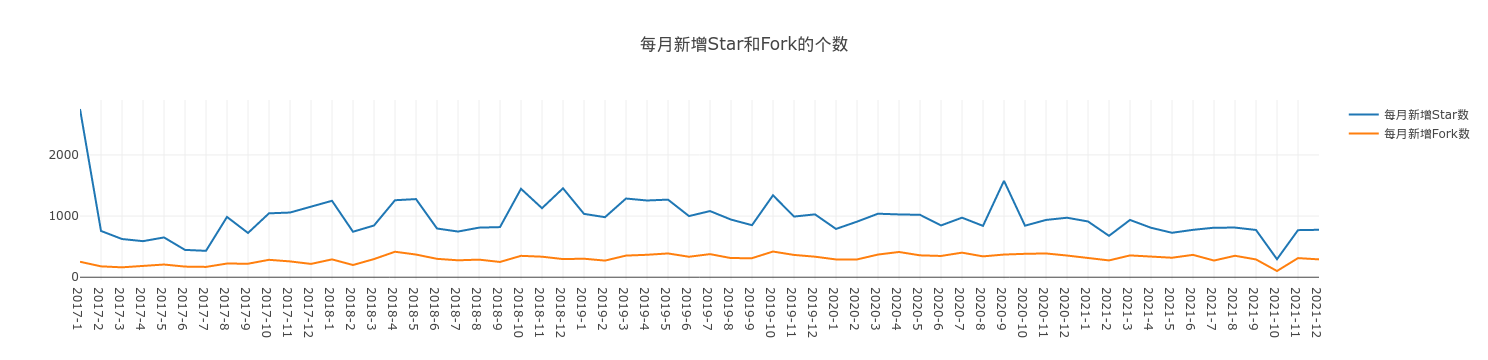

┌─────────┬───────────┬────────┬───────┐
│ (index) │   Time    │  Star  │ Fork  │
├─────────┼───────────┼────────┼───────┤
│    0    │ '2017-1'  │ '2751' │ '253' │
│    1    │ '2017-2'  │ '757'  │ '178' │
│    2    │ '2017-3'  │ '625'  │ '162' │
│    3    │ '2017-4'  │ '590'  │ '191' │
│    4    │ '2017-5'  │ '651'  │ '208' │
│    5    │ '2017-6'  │ '447'  │ '174' │
│    6    │ '2017-7'  │ '432'  │ '169' │
│    7    │ '2017-8'  │ '986'  │ '224' │
│    8    │ '2017-9'  │ '724'  │ '221' │
│    9    │ '2017-10' │ '1045' │ '285' │
│   10    │ '2017-11' │ '1058' │ '259' │
│   11    │ '2017-12' │ '1156' │ '218' │
│   12    │ '2018-1'  │ '1250' │ '292' │
│   13    │ '2018-2'  │ '744'  │ '200' │
│   14    │ '2018-3'  │ '846'  │ '297' │
│   15    │ '2018-4'  │ '1259' │ '417' │
│   16    │ '2018-5'  │ '1278' │ '371' │
│   17    │ '2018-6'  │ '797'  │ '301' │
│   18    │ '2018-7'  │ '747'  │ '277' │
│   19    │ '2018-8'  │ '811'  │ '288' │
│   20    │ '2018-9'  │ '820'  │ '250' │
│   21    │ '201

In [9]:
query(
    `
    select
    toYear(created_at) as year, toMonth(created_at) as month,
    count(type='WatchEvent' or NULL) as star,
    count(type='ForkEvent' or NULL) as fork
    from github_log.events
    where repo_id=${repo_id} and year>=${startYear} and year<=${endYear}
    group by year, month
    order by year, month
    `
).then(data => {
    var starCount = [], forkCount = [], timeline = [], table = [];
    data.forEach(d => {
        starCount.push(d.star);
        forkCount.push(d.fork);
        var time = d.year + '-' + d.month;
        timeline.push(time);
        table.push({'Time': time, 'Star': d.star, 'Fork': d.fork});
    });
    openDigger.render.plotly([
        {x: timeline, y: starCount, mode: 'scatter', name: '每月新增Star数'},
        {x: timeline, y: forkCount, mode: 'scatter', name: '每月新增Fork数'},
    ], {
        title: '每月新增Star和Fork的个数',
        xaxis: {type: 'category'},
    });
    console.table(table);
})

## 2. 每月打开 Issue 和 关闭 Issue 的个数

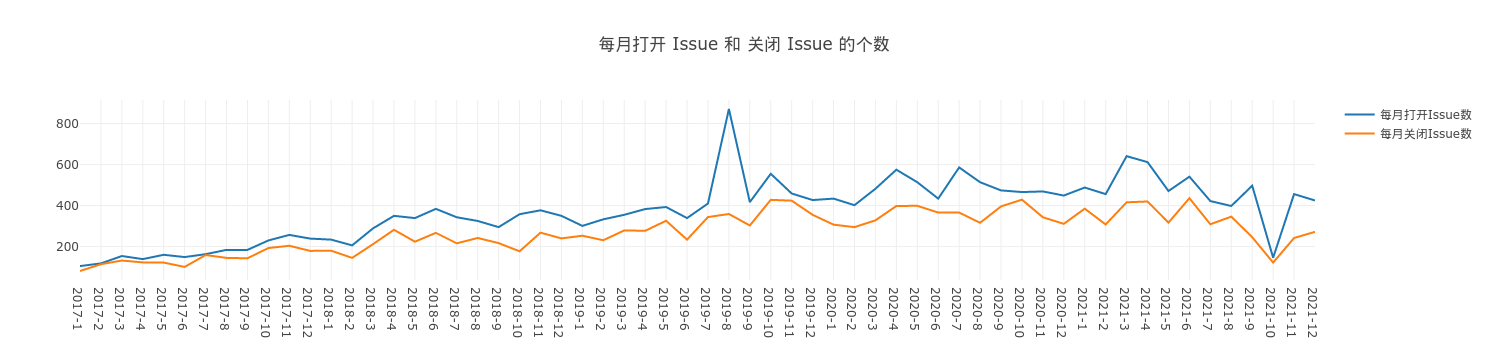

┌─────────┬───────────┬───────────────┬───────────────┐
│ (index) │   Time    │ Opened Issues │ Closed Issues │
├─────────┼───────────┼───────────────┼───────────────┤
│    0    │ '2017-1'  │     '105'     │     '81'      │
│    1    │ '2017-2'  │     '118'     │     '114'     │
│    2    │ '2017-3'  │     '154'     │     '132'     │
│    3    │ '2017-4'  │     '139'     │     '123'     │
│    4    │ '2017-5'  │     '160'     │     '122'     │
│    5    │ '2017-6'  │     '149'     │     '101'     │
│    6    │ '2017-7'  │     '163'     │     '159'     │
│    7    │ '2017-8'  │     '184'     │     '145'     │
│    8    │ '2017-9'  │     '184'     │     '143'     │
│    9    │ '2017-10' │     '230'     │     '193'     │
│   10    │ '2017-11' │     '257'     │     '204'     │
│   11    │ '2017-12' │     '239'     │     '179'     │
│   12    │ '2018-1'  │     '234'     │     '180'     │
│   13    │ '2018-2'  │     '206'     │     '145'     │
│   14    │ '2018-3'  │     '289'     │     '212

In [10]:
query(
    `
    select
    toYear(created_at) as year, toMonth(created_at) as month,
    count(action='opened' or NULL) as open,
    count(action='closed' or NULL) as close
    from github_log.events
    where repo_id=${repo_id} and type='IssuesEvent' and year>=${startYear} and year<=${endYear}
    group by year, month
    order by year, month
    `
).then(data => {
    var openCount = [], closeCount = [], timeline = [], table = [];
    data.forEach(d => {
        openCount.push(d.open);
        closeCount.push(d.close);
        var time = d.year + '-' + d.month;
        timeline.push(time);
        table.push({'Time': time, 'Opened Issues': d.open, 'Closed Issues': d.close});
    });
    openDigger.render.plotly([
        {x: timeline, y: openCount, mode: 'scatter', name: '每月打开Issue数'},
        {x: timeline, y: closeCount, mode: 'scatter', name: '每月关闭Issue数'},
    ], {
        title: '每月打开 Issue 和 关闭 Issue 的个数',
        xaxis: {type: 'category'},
    });
    console.table(table);
})

## 3. 每月打开 PR 和合入 PR 的个数（注意，关闭 PR 不等于合入）

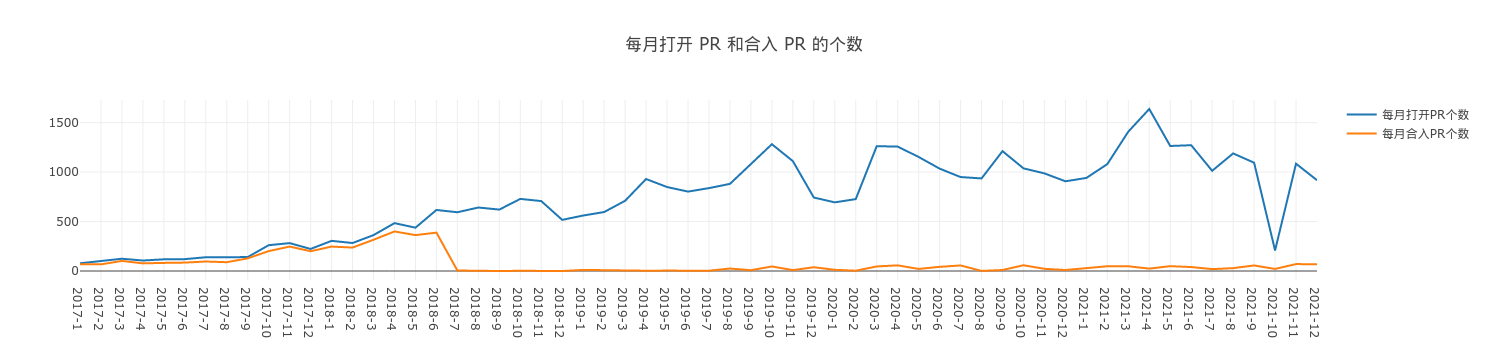

┌─────────┬───────────┬───────────┬───────────┐
│ (index) │   Time    │ Opened PR │ Merged PR │
├─────────┼───────────┼───────────┼───────────┤
│    0    │ '2017-1'  │   '78'    │   '68'    │
│    1    │ '2017-2'  │   '100'   │   '67'    │
│    2    │ '2017-3'  │   '124'   │   '102'   │
│    3    │ '2017-4'  │   '106'   │   '77'    │
│    4    │ '2017-5'  │   '118'   │   '82'    │
│    5    │ '2017-6'  │   '120'   │   '85'    │
│    6    │ '2017-7'  │   '139'   │   '96'    │
│    7    │ '2017-8'  │   '139'   │   '89'    │
│    8    │ '2017-9'  │   '141'   │   '128'   │
│    9    │ '2017-10' │   '261'   │   '201'   │
│   10    │ '2017-11' │   '282'   │   '247'   │
│   11    │ '2017-12' │   '223'   │   '200'   │
│   12    │ '2018-1'  │   '305'   │   '247'   │
│   13    │ '2018-2'  │   '283'   │   '237'   │
│   14    │ '2018-3'  │   '363'   │   '316'   │
│   15    │ '2018-4'  │   '484'   │   '400'   │
│   16    │ '2018-5'  │   '438'   │   '363'   │
│   17    │ '2018-6'  │   '617'   │   '3

In [11]:
query(
    `
    select
    toYear(created_at) as year, toMonth(created_at) as month,
    count(action='opened' or NULL) as open,
    count(pull_merged=1 or NULL) as merge
    from github_log.events
    where repo_id=${repo_id} and type='PullRequestEvent' and year>=${startYear} and year<=${endYear}
    group by year, month
    order by year, month
    `
).then(data => {
    var openCount = [], mergeCount = [], timeline = [], table = [];
    data.forEach(d => {
        openCount.push(d.open);
        mergeCount.push(d.merge);
        var time = d.year + '-' + d.month;
        timeline.push(time);
        table.push({'Time': time, 'Opened PR': d.open, 'Merged PR': d.merge});
    });
    openDigger.render.plotly([
        {x: timeline, y: openCount, mode: 'scatter', name: '每月打开PR个数'},
        {x: timeline, y: mergeCount, mode: 'scatter', name: '每月合入PR个数'},
    ], {
        title: '每月打开 PR 和合入 PR 的个数',
        xaxis: {type: 'category'},
    });
    console.table(table);
})

## 4. 每月在仓库中活跃（只要有日志产生就算）的不同开发者（也就是一个GitHub账号）总数

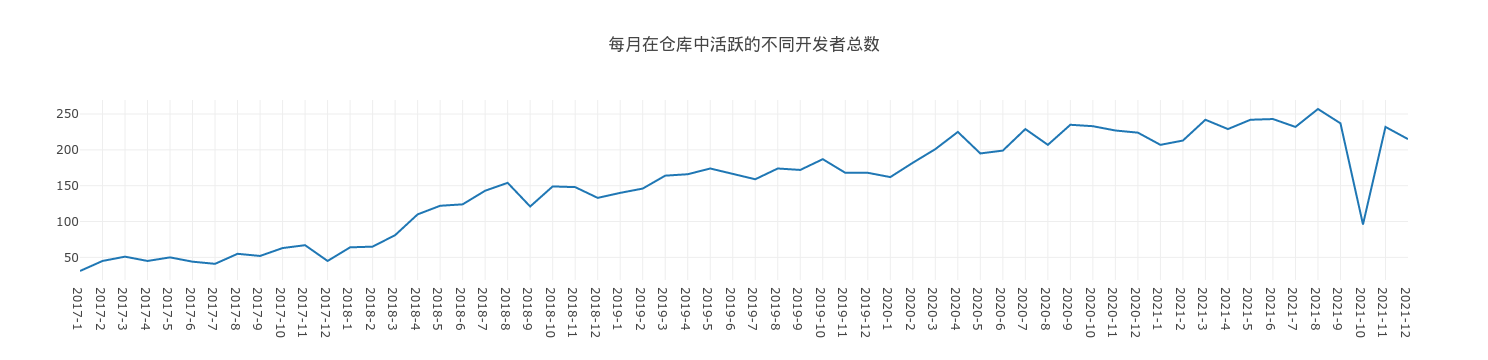

┌─────────┬───────────┬──────────────┐
│ (index) │   Time    │ Actived User │
├─────────┼───────────┼──────────────┤
│    0    │ '2017-1'  │     '31'     │
│    1    │ '2017-2'  │     '45'     │
│    2    │ '2017-3'  │     '51'     │
│    3    │ '2017-4'  │     '45'     │
│    4    │ '2017-5'  │     '50'     │
│    5    │ '2017-6'  │     '44'     │
│    6    │ '2017-7'  │     '41'     │
│    7    │ '2017-8'  │     '55'     │
│    8    │ '2017-9'  │     '52'     │
│    9    │ '2017-10' │     '63'     │
│   10    │ '2017-11' │     '67'     │
│   11    │ '2017-12' │     '45'     │
│   12    │ '2018-1'  │     '64'     │
│   13    │ '2018-2'  │     '65'     │
│   14    │ '2018-3'  │     '81'     │
│   15    │ '2018-4'  │    '110'     │
│   16    │ '2018-5'  │    '122'     │
│   17    │ '2018-6'  │    '124'     │
│   18    │ '2018-7'  │    '143'     │
│   19    │ '2018-8'  │    '154'     │
│   20    │ '2018-9'  │    '121'     │
│   21    │ '2018-10' │    '149'     │
│   22    │ '2018-11' │  

In [12]:
query(
    `
    select
    toYear(created_at) as year, toMonth(created_at) as month,
    count(DISTINCT actor_id) as user
    from github_log.events
    where repo_id=${repo_id} and type='PullRequestEvent' and year>=${startYear} and year<=${endYear}
    group by year, month
    order by year, month
    `
).then(data => {
    var userCount = [], mergeCount = [], timeline = [], table = [];
    data.forEach(d => {
        userCount.push(d.user);
        var time = d.year + '-' + d.month;
        timeline.push(time);
        table.push({'Time': time, 'Actived User': d.user});
    });
    openDigger.render.plotly([
        {x: timeline, y: userCount, mode: 'scatter', name: '每月活跃的开发者个数'},
    ], {
        title: '每月在仓库中活跃的不同开发者总数',
        xaxis: {type: 'category'},
    });
    console.table(table);
})

## 5. Issue 从打开到关闭的平均时长和中位数（单位：天）

In [13]:
query(
    `
    SELECT
    avg(duration) as avg, quantile(0.5)(duration) as medium 
    FROM (
        SELECT 
        toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration
        FROM github_log.events
        WHERE repo_id=${repo_id} AND type='IssuesEvent' AND duration>=0
    )`
).then(res => {console.log(res[0]);})

{ avg: 98.71833118376044, medium: 6 }


## 6. PR 从打开到合入的平均时长和中位数（单位：天）

In [14]:
query(
    `
    SELECT
    avg(duration) as avg, quantile(0.5)(duration) as medium
    FROM (
        SELECT
        intDiv(minus(max(created_at), min(created_at))/3600, 24) AS duration
        FROM (
            SELECT 
            issue_id, created_at
            FROM github_log.events
            WHERE repo_id=${repo_id} AND type='PullRequestEvent'
        ) GROUP BY issue_id
    )`
).then(res => {console.log(res[0]);})

{ avg: 29.457775007790588, medium: 1 }


## 7. Issue和PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

In [15]:
query(
    `
    SELECT
    avg(duration) as avg, quantile(0.5)(duration) as medium
    FROM (
        SELECT
        minus(toRelativeDayNum(min(issue_comment_created_at)), toRelativeDayNum(min(issue_created_at))) AS duration 
        FROM (
            SELECT
            issue_id, issue_created_at, issue_comment_created_at
            FROM github_log.events
            WHERE repo_id=${repo_id} AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
        ) GROUP BY issue_id
    )`
).then(res => {console.log(res[0]);})

{ avg: 16.428937900324293, medium: 0 }
